## Machine Learning Lista 04
### Douglas Gaspar Feitosa Freitas - 473552


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import MinMaxScaler

# Importar os dados
data = pd.read_csv('concrete.csv')

# Separar os atributos e a saída
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Dividir em conjuntos de treino, validação, e teste
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

# Normalizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## Questão 01
Considere o conjunto de dados disponível em **concrete.csv**, organizado em 9 colunas, sendo as 8 primeiras colunas os atributos e a última coluna a saída. Os 8 atributos referem-se à caracterização de diferentes tipos de concreto para construção civil. A saída é a resistência à compressão do concreto (em megapascals, MPa). Maiores detalhes sobre os dados podem ser conferidos em https://www.openml.org/d/4353

a) Considere um modelo de regressão não linear baseado em redes neurais artificiais. Separe os dados aleatoriamente em treino, validação e teste (por exemplo, 60%, 20% e 20%). Nesse cenário, treine e avalie o modelo abaixo:
   – **MLP (multilayer perceptron)**: 1 camada oculta e treinamento em minibatch via gradiente descendente estocástico com termo de momentum. Utilize o conjunto de validação para ajustar os hiperparâmetros.

b) Apresente as curvas da função custo nos conjuntos de treinamento e validação ao longo das épocas. Reporte também para os conjuntos de treino, validação e teste as métricas abaixo:  
– **RMSE (root mean squared error)**;  
– **MAE (mean absolute error)**;  
– **MRE (mean relative error)**.

In [6]:
#mlp = MLPRegressor(hidden_layer_sizes=(10,), solver='sgd', max_iter=1100, momentum=0.9, batch_size=32, random_state=42)
#mlp.fit(X_train, y_train)

simplefilter("ignore", category=ConvergenceWarning)

# Define o número de epochs
n_epochs = 3000

# Inicializa o regressor
mlp_reg = MLPRegressor(max_iter = n_epochs, solver = 'sgd')

# Inicializa os vetores de loss
train_losses = []
val_losses = []
test_losses = []

# Define parâmetros a serem otimizados.
parameters = {'hidden_layer_sizes':[(10,), (50,), (100,)], 'activation': ['logistic','relu', 'tanh'], 'momentum': [0.85, 0.9, 0.95, 0.99],
              'batch_size':[16, 32, 64, 'auto']}

# Concatena Train e Validation para que o GridSearch use o set de Validation por meio do Split Index. Um pouco clunky, IMO
split_index = [-1]*len(X_train) + [0]*len(X_val)
X_gs = np.concatenate((X_train, X_val), axis=0)
y_gs = np.concatenate((y_train, y_val), axis=0)
pds = PredefinedSplit(test_fold = split_index)

# Define como deve ser calculado o score do Grid Search
scorer = make_scorer(rmse, greater_is_better=False)

# Usa o Grid Search
grid_search = GridSearchCV(mlp_reg, parameters, scoring = scorer, cv = pds)
grid_search.fit(X_gs, y_gs)

print("Melhores hiperparâmetros encontrados:")
print(grid_search.best_params_)

# Obtém o estimador com os melhores parâmetros
mlp = grid_search.best_estimator_

#params_svm = {"max_iter":1, "warm_start":True}
#mlp = mlp.set_params(**params_svm)

# Treina o melhor estimador
#mlp.fit(X_train, y_train)

for epoch in range(n_epochs):
    mlp.partial_fit(X_train, y_train)

    # Calcula o custo para cada set
    train_loss = rmse(y_train, mlp.predict(X_train))
    val_loss = rmse(y_val, mlp.predict(X_val))
    test_loss = rmse(y_test, mlp.predict(X_test))

    # Armazena os custos
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)

# Predições
y_train_pred = mlp.predict(X_train)
y_val_pred = mlp.predict(X_val)
y_test_pred = mlp.predict(X_test)

# Avaliação

rmse_train = rmse(y_train, y_train_pred)
rmse_val = rmse(y_val, y_val_pred)
rmse_test = rmse(y_test, y_test_pred)

mae_train = mae(y_train, y_train_pred)
mae_val = mae(y_val, y_val_pred)
mae_test = mae(y_test, y_test_pred)

mre_train = (abs(y_train - y_train_pred) / y_train).mean()
mre_val = (abs(y_val - y_val_pred) / y_val).mean()
mre_test = (abs(y_test - y_test_pred) / y_test).mean()

Melhores hiperparâmetros encontrados:
{'activation': 'tanh', 'batch_size': 16, 'hidden_layer_sizes': (100,), 'momentum': 0.9}


RMSE - Treino: 1.3885904708114107, Validação: 4.7921539715199915, Teste: 5.622035670430214
MAE - Treino: 0.5190009047804321, Validação: 3.2913715157176315, Teste: 3.757008197071389
MRE - Treino: 0.01907153429024144, Validação: 0.10784182803201164, Teste: 0.12004209947635926


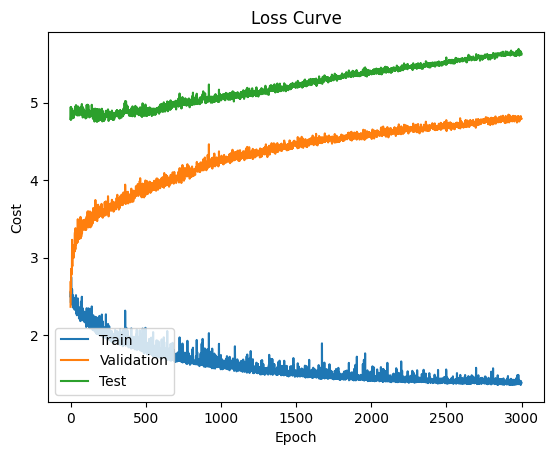

In [7]:
print(f"RMSE - Treino: {rmse_train}, Validação: {rmse_val}, Teste: {rmse_test}")
print(f"MAE - Treino: {mae_train}, Validação: {mae_val}, Teste: {mae_test}")
print(f"MRE - Treino: {mre_train}, Validação: {mre_val}, Teste: {mre_test}")

plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.plot(test_losses, label="Test")
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.legend(loc="lower left")
plt.show()

## Questão 2
Considere o conjunto de dados disponível em **vowel.csv**, organizado em 11 colunas, sendo as 10 primeiras colunas os atributos e a última coluna a saída. Os 10 atributos referem-se à caracterização de amostras da fala de britânicos. A saída é o fonema de vogal correspondente, dentre as 11 possibilidades. Maiores detalhes sobre os dados podem ser conferidos em https://www.openml.org/d/307.  
a) Considere um modelo de classificação não linear baseado em redes neurais artificiais. Separe os dados aleatoriamente em treino, validação e teste (por exemplo, 60%, 20% e 20%). Nesse cenário, treine e avalie o modelo abaixo:  
– **MLP (multilayer perceptron)**: 1 camada oculta e treinamento em minibatch via gradiente descendente estocástico com termo de momentum. Utilize o conjunto de validação para ajustar os hiperparâmetros.  
b) Apresente as curvas da função custo nos conjuntos de treinamento e validação ao longo das épocas. Reporte também a acurácia obtida para os conjuntos de treino, validação e teste.

Melhores hiperparâmetros encontrados:
{'activation': 'tanh', 'batch_size': 12, 'hidden_layer_sizes': (50,), 'momentum': 0.95}
Acurácia - Treino: 0.9949409780775716, Validação: 0.9646464646464646, Teste: 0.9141414141414141


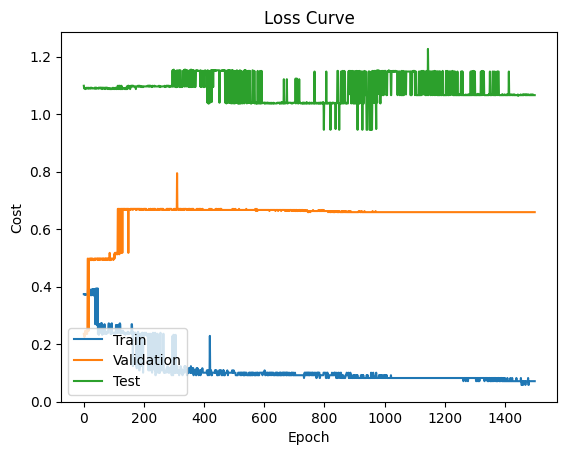

In [2]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

data = pd.read_csv('vowel.csv')

simplefilter("ignore", category=ConvergenceWarning)

# Separa os atributos e a saída
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Inicializa o regressor
mlp_class = MLPClassifier(max_iter = 1500, solver = 'sgd')

# Define o número de epochs
n_epochs = 1500

# Inicializa os vetores de loss
train_losses = []
val_losses = []
test_losses = []

# Define parâmetros a serem otimizados.
parameters = {'hidden_layer_sizes':[(10,), (50,), (100,)], 'activation': ['relu', 'tanh'], 'momentum': [0.9, 0.95, 0.99],
              'batch_size':[12, 16, 32, 64, 'auto']}

# Concatena Train e Validation para que o GridSearch use o set de Validation por meio do Split Index. Um pouco clunky, IMO
split_index = [-1]*len(X_train) + [0]*len(X_val)
X_gs = np.concatenate((X_train, X_val), axis=0)
y_gs = np.concatenate((y_train, y_val), axis=0)
pds = PredefinedSplit(test_fold = split_index)

# Define como deve ser calculado o score do Grid Search
scorer = make_scorer(rmse, greater_is_better=False)

# Usa o Grid Search
grid_search = GridSearchCV(mlp_class, parameters, scoring = scorer, cv = pds)
grid_search.fit(X_gs, y_gs)

print("Melhores hiperparâmetros encontrados:")
print(grid_search.best_params_)

mlp = grid_search.best_estimator_

params_svm = {"max_iter":1, "warm_start":True}
mlp = mlp.set_params(**params_svm)

# Treina o melhor estimador
for epoch in range(n_epochs):
    mlp.fit(X_train, y_train)

    # Calcula o custo para cada set
    train_loss = rmse(y_train, mlp.predict(X_train))
    val_loss = rmse(y_val, mlp.predict(X_val))
    test_loss = rmse(y_test, mlp.predict(X_test))

    # Armazena os custos
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)

mlp.fit(X_train, y_train)

# Predições
y_train_pred = mlp.predict(X_train)
y_val_pred = mlp.predict(X_val)
y_test_pred = mlp.predict(X_test)

acc_train = accuracy_score(y_train, y_train_pred)
acc_val = accuracy_score(y_val, y_val_pred)
acc_test = accuracy_score(y_test, y_test_pred)

print(f"Acurácia - Treino: {acc_train}, Validação: {acc_val}, Teste: {acc_test}")

plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.plot(test_losses, label="Test")
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.legend(loc="lower left")
plt.show()

Primeiro, que desgraça esse sklearn. Depois de sofrer muito com ele e lidar com DOIS PROBLEMAS reportados *há anos* (https://github.com/scikit-learn/scikit-learn/issues/24411, https://github.com/scikit-learn/scikit-learn/issues/13656), eu mudei pro Keras.